In [1]:
import numpy as np
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter
from scipy import interpolate

import h5py
from scipy.stats import binned_statistic_2d

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patches as patches
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=20)
from matplotlib.colors import LogNorm

In [2]:
# Plotting properties
grey = '#3C3C3C'
from matplotlib import rc
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.color'] = grey
mpl.rcParams['ytick.color'] = grey
mpl.rcParams['axes.edgecolor'] = grey
mpl.rcParams['axes.labelcolor'] = grey
mpl.rcParams.update({'figure.autolayout': True})
rc('axes', linewidth=1.5)
rc('axes', edgecolor=grey)
labels_font = {'size':'20'} 

In [3]:
Msol_to_g = 1.99E33
pc_to_cm = 3.086E18
kpc_to_cm = 3.086E21
Myr_to_s = 3.15576E13
mu = 0.63
mp = 1.67E-24
kB = 1.38E-16

width_kpc = 4.
width = width_kpc * kpc_to_cm

# gas morphology

In [4]:
def get_image_data(filename):
    with open(filename, "rb") as f:
        xpix = np.fromfile(f, dtype=np.int32, count=1)[0]
        ypix = np.fromfile(f, dtype=np.int32, count=1)[0]
        img = np.fromfile(f, dtype=np.float32, count=xpix*ypix)
    img = np.reshape(img, (xpix, ypix))
    img = np.rot90(img)
    return img

In [5]:
def downsample(myarr, factor, estimator=np.nanmean):
    # downsample a 2D array by averaging over *factor* pixels in each axis.
    # crops upper edge if the shape is not a multiple of factor.
    # this code is pure np and should be fast.
    ys,xs = myarr.shape
    crarr = myarr[:ys-(ys % int(factor)),:xs-(xs % int(factor))]
    dsarr = estimator(np.concatenate([[crarr[i::factor,j::factor] 
        for i in range(factor)] 
        for j in range(factor)]), axis=0)
    return dsarr

In [6]:
# all gas
imgsf = [
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/density_proj_400'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/lowM-output/density_proj_400'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/medM-output/density_proj_399'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/hiM-output/density_proj_399'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/MW-tracers/density_proj_600'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/NGC300/density_proj_799'),
]
imgse = [
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/edge-on/density_proj_400'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/lowM-output/edge-on/density_proj_400'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/medM-output/edge-on/density_proj_399'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/hiM-output/edge-on/density_proj_399'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/MW-tracers/edge-on/density_proj_600'),
    get_image_data('/n/holystore01/LABS/itc_lab/Users/sjeffreson/NGC300/edge-on/density_proj_799'),
]

labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          r"Milky Way-like",
          r"NGC~300-like"]

# figure

/tmp/ipykernel_2280872/2773641796.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(


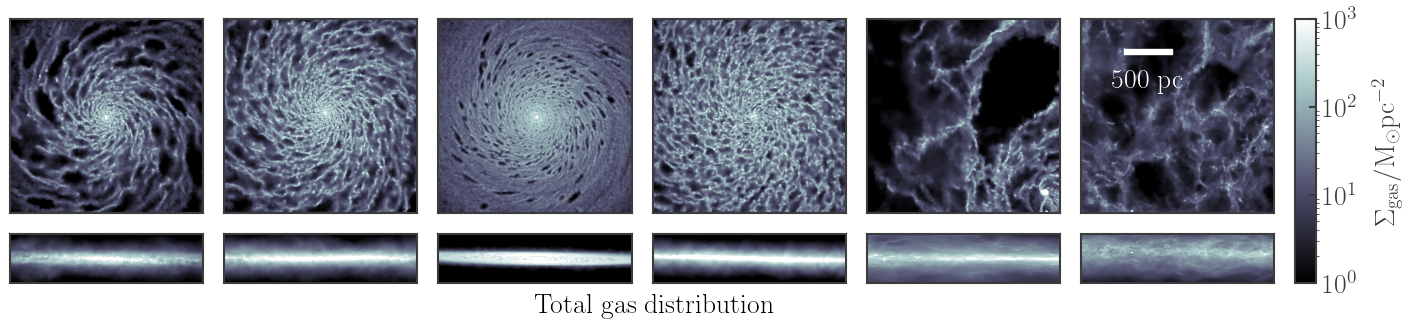

In [15]:
figW = 14
figH = 3.
fig = plt.figure(figsize=(figW, figH))

botMarg = 0.1
wBetMarg = 0.015
topMarg = 0.02
leftMarg = 0.1
hBetMarg = 0.07

crightMarg = 0.105
cW = 0.015
cBet = 0.002
rightMarg = 0.03 + crightMarg + cW

h = (1.0-topMarg-hBetMarg-botMarg)/5.
w = (1.0-leftMarg-4.*wBetMarg-rightMarg)/5.

### axes ###

# total gas
ax1f0 = fig.add_axes([leftMarg, botMarg+h+hBetMarg, w, 4*h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1f1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg+h+hBetMarg, w, 4*h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1f2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg+h+hBetMarg, w, 4*h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1f3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg+h+hBetMarg, w, 4*h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1f4 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg+h+hBetMarg, w, 4*h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1f5 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg+h+hBetMarg, w, 4*h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
axs1f = [ax1f0, ax1f1, ax1f2, ax1f3, ax1f4, ax1f5]
ax1e0 = fig.add_axes([leftMarg, botMarg, w, h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1e1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1e2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg, w, h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1e3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg, w, h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1e4 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg, w, h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
ax1e5 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg, w, h],
                 xlabel='', ylabel='', xticklabels='', yticklabels='')
axs1e = [ax1e0, ax1e1, ax1e2, ax1e3, ax1e4, ax1e5]
cax1 = fig.add_axes([leftMarg+6*(w+wBetMarg), botMarg, cW, 5*h+hBetMarg])
fig.text(0.56, 0., r'Total gas distribution', fontsize=20, horizontalalignment='center')

### plot maps on axes ###
# total gas
for ax, img in zip(axs1f[:-1], imgsf[:-1]):
    ax.tick_params(axis='both', which='both', length=0)
    mapgf1 = ax.imshow(
        img[167:500,167:500]*1.e10/(1.e3)**2, cmap=plt.cm.bone, norm=LogNorm(vmin = 1., vmax = 1000.),
        aspect='auto', extent=[-width_kpc/4., width_kpc/4., -width_kpc/4., width_kpc/4.]
    )
ax1f4.tick_params(axis='both', which='both', length=0)
mapgf1 = ax1f4.imshow(
    imgsf[4][2167:2500,2167:2500]*1.e9/(1.e3)**2, cmap=plt.cm.bone, norm=LogNorm(vmin=1., vmax=1000.),
    aspect='auto', extent=[-width_kpc/2., 0., 0., width_kpc/2.]
)
ax1f5.tick_params(axis='both', which='both', length=0)
mapgf1 = ax1f5.imshow(
    imgsf[5][333:1000,333:1000]*1.e10/(1.e3)**2, cmap=plt.cm.bone, norm=LogNorm(vmin=1., vmax=1000.),
    aspect='auto', extent=[-width_kpc/2., 0., 0., width_kpc/2.]
)
    
for ax, img in zip(axs1e[:-1], imgse[:-1]):
    ax.tick_params(axis='both', which='both', length=0)
    mapge1 = ax.imshow(
        img[20:63,167:500]*1.e10/(1.e3)**2, cmap=plt.cm.bone, norm=LogNorm(vmin = 1., vmax = 1000.),
        aspect='auto', extent=[-width_kpc/4., width_kpc/4., -width_kpc/8., width_kpc/8.],
    )
ax1e4.tick_params(axis='both', which='both', length=0)
ax1e4.imshow(
    imgse[4][250:583,2167:2500]*1.e9/(1.e3)**2, cmap=plt.cm.bone, norm=LogNorm(vmin = 1., vmax = 1000.),
    aspect='auto', extent=[-width_kpc/4., width_kpc/4., -width_kpc/8., width_kpc/8.],
)
ax1e5.tick_params(axis='both', which='both', length=0)
ax1e5.imshow(
    imgse[5][250:583,333:1000]*1.e10/(1.e3)**2, cmap=plt.cm.bone, norm=LogNorm(vmin = 1., vmax = 1000.),
    aspect='auto', extent=[-width_kpc/4., width_kpc/4., -width_kpc/8., width_kpc/8.],
)
    
### colorbars ###
cbar1 = fig.colorbar(mapgf1, cax=cax1)
cbar1.set_label(r'$\Sigma_{\rm gas}/{\rm M}_\odot {\rm pc}^{-2}$')
cax1.tick_params(axis='both', direction='in', top=True, bottom=False)
    
### scale-bars ###
scalebar = AnchoredSizeBar(
    ax1f5.transData, 0.5, '500~pc', 'upper left',
    color='white', frameon=False, size_vertical=0.05, pad=1., sep=10,
    fontproperties=fontprops
)
ax1f5.add_artist(scalebar)

plt.savefig(
    '/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/figs/dataset_HR.pdf',
    bbox_inches='tight',
    format='pdf'
)

plt.show()